# Hexagon particle interpolation

This is a stub in which I try to get hexagon particle interpolation to work in a way that is more efficient than Stripy's build-in interpolation scheme. It globally works as follows:
 - Create a triangular mesh using `stripy` and calculate its centroids
 - Since the triangles are equilaterals, the centroids roughly coincide with the voronoi generator vertices
 - Refine the mesh through a delauney triangulation in
 
Previous attempts include
 - Using a KDTree and plotting using a Spherical Voronoi diagram. The plots failed due to precision.
 - Find the nearest triangle vertex to a particle
     - Do this through a sorted search with a certain distance tolerance
     - Check the angle that the particle makes to this vertex with respect to the angles made by the neighboring vertices. Angles are measured with respect to the local North
     - From this, we can check which triangle the particle is in (particle's angle is wedged between two other angles; compute angles)
     - Look up the hex_id of the triangle the particle is in

In [16]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
import scipy
import xarray as xr
from importlib import reload

import sys
sys.path.append('/home/students/4302001/arctic-connectivity/tools')
sys.path.append('/Users/daanreijnders/surfdrive/Thesis/repo/tools')
import plot
import lifeline
import community
import fieldsetter
import advectParticles

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.collections import PolyCollection
from astropy.coordinates import cartesian_to_spherical, spherical_to_cartesian
import cartopy as cart
import cartopy.crs as ccrs

from numba import jit, njit
import stripy

import sys
sys.path.append('/home/students/4302001/arctic-connectivity/tools')
sys.path.append('/Users/daanreijnders/surfdrive/Thesis/repository/tools')
import plot
import lifeline
import community
import fieldsetter
import advectParticles

In [4]:
# Loading and subsetting particle set
testParticles = community.particles.from_pickle('/Users/daanreijnders/Datasets/Meshes/ico_mesh_parts_r11.pickle')
print("Size before subsetting", testParticles.n)
domainMask = np.logical_and(np.logical_and(np.degrees(testParticles.lats) > 60, 
                                           np.degrees(testParticles.lats) < 85),
                            np.logical_and(np.degrees(testParticles.lons) < 70,
                                           np.degrees(testParticles.lons) > -45))
pLons = np.degrees(testParticles.lons)[domainMask]
pLats = np.degrees(testParticles.lats)[domainMask]
testParticles = community.particles(pLons, pLats)
print("Size after subsetting", testParticles.n)

Size before subsetting 41943042
Size after subsetting 894855


In [5]:
# Create icosahedral mesh
ico = stripy.spherical_meshes.icosahedral_mesh(refinement_levels=7)
facepoints_lons, facepoints_lats = ico.face_midpoints()
icof = stripy.sTriangulation(np.hstack((ico.lons, facepoints_lons)), np.hstack((ico.lats, facepoints_lats)))
identifier = np.ones(icof.npoints)
identifier[ico.npoints:] = 0 # make index of last face 0
hex_id = icof.simplices[np.where(identifier[icof.simplices] == 1.0)]

In [110]:
identifier

array([1., 1., 1., ..., 0., 0., 0.])

In [111]:
icof.npoints

491522

In [112]:
np.where(identifier[icof.simplices] == 1.0)[0].shape

(983040,)

In [113]:
bleed = 2
binMask = np.logical_and(np.logical_and(np.degrees(ico.lats) > 60-bleed, 
                                        np.degrees(ico.lats) < 85+bleed),
                         np.logical_and(np.degrees(ico.lons) < 70+bleed,
                                        np.degrees(ico.lons) > -45-bleed))
binMaskIndices = ico._permutation[binMask]

In [114]:
simplexMask = np.any(np.array([i in binMaskIndices for i in icof.simplices.flatten()]).reshape(icof.simplices.shape), axis=1)

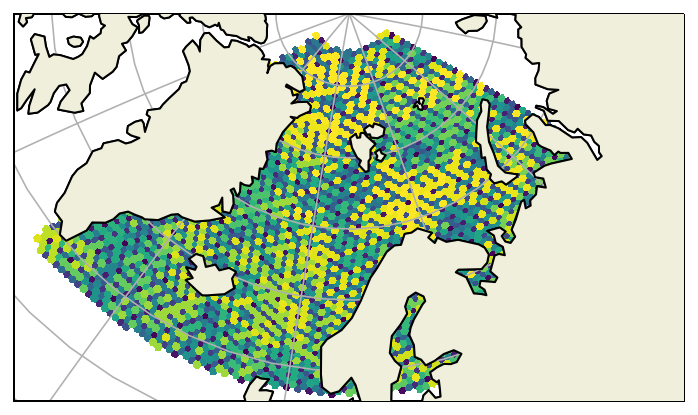

In [115]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.Stereographic(central_latitude=70, central_longitude=10.0))
ax.gridlines()
ax.coastlines()
ax.add_feature(cart.feature.LAND, zorder=5, edgecolor='k')
ax.set_extent((-50,70,57.5,90), crs=ccrs.PlateCarree())
ax.tripcolor(np.degrees(icof.lons), np.degrees(icof.lats), triangles=icof.simplices[simplexMask], facecolors=hex_id[simplexMask], transform=ccrs.Geodetic(), zorder=1)
plt.show()

In [198]:
# Note that these bins are not exactly the same as the voronoi vertices

In [116]:
tree = scipy.spatial.cKDTree(6371000*ico.points)

In [117]:
def get_cartesian(lon=None, lat=None, mode='rad'):
    if mode=='deg':
        lat, lon = np.radians(lat), np.radians(lon)
    R = 6371000 # radius of the earth
    x = R * np.cos(lat) * np.cos(lon)
    y = R * np.cos(lat) * np.sin(lon)
    z = R *np.sin(lat)
    return x,y,z

In [118]:
xp, yp, zp = get_cartesian(pLons, pLats, mode='deg')

In [119]:
tree.query(np.dstack((xp, yp, zp))[0])

(array([2.32830644e-10, 5.20625146e-10, 0.00000000e+00, ...,
        1.85964240e+04, 1.64664857e+04, 6.66655516e+03]),
 array([   64,    77,   102, ..., 46746,   488,   488]))

In [120]:
closest = tree.query(np.dstack((xp, yp, zp))[0])[1]

In [172]:
vals, counts = np.unique(closest, return_counts=True)
transdict = dict(zip(vals, counts))

In [185]:
hexCountsMasked = np.array([transdict[i] if i in transdict.keys() else 0 for i in hex_id[simplexMask]])

In [186]:
hexCountsMasked.shape

(24726,)

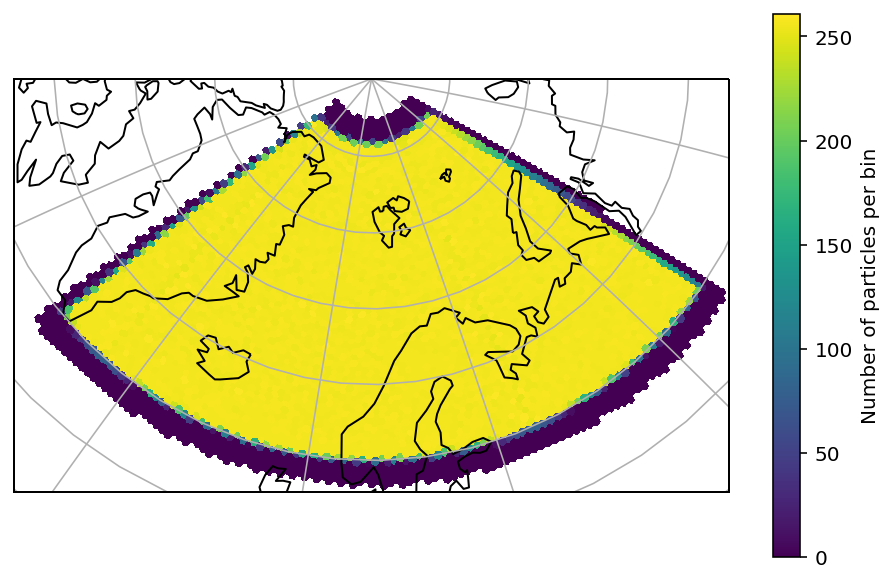

In [196]:
fig = plt.figure(figsize=(8,5))
ax = plt.axes(projection=ccrs.Stereographic(central_latitude=70, central_longitude=10.0))
ax.gridlines()
ax.coastlines()
#ax.add_feature(cart.feature.LAND, zorder=5, edgecolor='k')
ax.set_extent((-50,70,57.5,90), crs=ccrs.PlateCarree())
hexPlot = ax.tripcolor(np.degrees(icof.lons), np.degrees(icof.lats), triangles=icof.simplices[simplexMask], facecolors=hexCountsMasked, transform=ccrs.Geodetic(), zorder=1)
cbar = fig.colorbar(hexPlot)
cbar.set_label("Number of particles per bin")
plt.savefig("hexbins.eps")
plt.show()


# Alternative method

In [182]:
# Create mask of domain in question
bleed = 3
binMask = np.logical_and(np.logical_and(np.degrees(ico.lats) > 60-bleed, 
                                        np.degrees(ico.lats) < 85+bleed),
                         np.logical_and(np.degrees(ico.lons) < 70+bleed,
                                        np.degrees(ico.lons) > -45-bleed))
binMaskIndices = [i for i in np.arange(len(binMask)) if binMask[i]]

In [183]:
binMaskFine = np.logical_and(np.logical_and(np.degrees(icof.lats) > 60-bleed, 
                                            np.degrees(icof.lats) < 85+bleed),
                             np.logical_and(np.degrees(icof.lons) < 70+bleed,
                                            np.degrees(icof.lons) > -45-bleed))
binMaskFineIndices = [i for i in np.arange(len(binMaskFine)) if binMaskFine[i]]

In [184]:
# First (binMask.shape[0]) indices of binMaskFine are equal to those of binMask!
np.all(binMask == binMaskFine[0:binMask.shape[0]])

True

In [206]:
generatorLonLat = np.dstack((np.degrees(ico.lons), np.degrees(ico.lats)))[0]
fineLonLat = np.dstack((np.degrees(icof.lons), np.degrees(icof.lats)))[0]

# Save ids
generatorVertexIdx = ico._permutation
refinedVertexIdx = icof._permutation
# Save subset of IDs
subGeneratorVertexIdx = generatorVertexIdx[binMask]
# Create indices for each simplex (triangle)
simplexIdx = np.arange(icof._simplices.shape[0])
# Create empty dictionaries for lookup of neighbors of vertices, simplices that vertices are in
# and angles formed between vertices and their neighbors. vertexIDs are keys.
vertexDict = {}
for i in refinedVertexIdx:
    vertexDict[i] = {'neighbors' : set(), 
                     'inSimplices' : set()}

# For each simplex, fill dictionary with simplex and neighbor information
for simplex in simplexIdx:   
    currSimplex = icof._simplices[simplex]
    vertexDict[currSimplex[0]]['inSimplices'].add(simplex)
    vertexDict[currSimplex[1]]['inSimplices'].add(simplex)
    vertexDict[currSimplex[2]]['inSimplices'].add(simplex)
    vertexDict[currSimplex[0]]['neighbors'].add(currSimplex[1])
    vertexDict[currSimplex[0]]['neighbors'].add(currSimplex[2])
    vertexDict[currSimplex[1]]['neighbors'].add(currSimplex[0])
    vertexDict[currSimplex[1]]['neighbors'].add(currSimplex[2])
    vertexDict[currSimplex[2]]['neighbors'].add(currSimplex[0])
    vertexDict[currSimplex[2]]['neighbors'].add(currSimplex[1])

In [213]:
vertexDict[0]['neighbors'].intersection(vertexDict[163842]['neighbors'])

{163843, 163846}

In [218]:
a = set([3])

In [224]:
for genVertex in generatorVertexIdx[binMask]:
    sortedNeighbors = []
    passed = set([genVertex])
    first = list(vertexDict[genVertex]['neighbors'])[0]
    curr = first
    sortedNeighbors.append(first)
    passed.add(first)
    while len(vertexDict[curr]['neighbors'].intersection(vertexDict[genVertex]['neighbors']).difference(passed)) > 0:
        curr = list(vertexDict[curr]['neighbors'].intersection(vertexDict[genVertex]['neighbors']).difference(passed))[0]
        sortedNeighbors.append(curr)
        passed.add(curr)
    vertexDict[genVertex]['sortedNeighbors'] = np.array(sortedNeighbors)

In [225]:
vertexDict[generatorVertexIdx[binMaskIndices[0]]]

{'neighbors': {163938, 163939, 163940, 163941, 163942, 163943},
 'inSimplices': {96, 97, 98, 99, 100, 101},
 'sortedNeighbors': array([163938, 163939, 163940, 163941, 163942, 163943], dtype=int32)}

In [226]:
for vertex in generatorVertexIdx[binMask]:
    assert 'sortedNeighbors' in vertexDict[vertex]

In [49]:
plotMask = np.logical_and(np.logical_and(binCenterLat > 60, 
                                         binCenterLat < 85),
                          np.logical_and(binCenterLon < 70,
                                         binCenterLon > -40))
plotMaskIndices = [i for i in np.arange(len(plotMask)) if plotMask[i]]

In [50]:
plotMask.shape

(3953,)

In [ ]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.Stereographic(central_latitude=70, central_longitude=10.0))
ax.gridlines()
ax.coastlines()
ax.add_feature(cart.feature.LAND, zorder=5, edgecolor='k')
ax.set_extent((-50,70,57.5,90), crs=ccrs.PlateCarree())
#plot each bin hexagonal bin. Problem seems to do with patch accuracy
plt.show()

# Voronoi method

In [185]:
sv = scipy.spatial.SphericalVoronoi(ico.points[binMask])
sv.sort_vertices_of_regions()
sv.points

array([[ 0.52573111,  0.        ,  0.85065081],
       [ 0.16245985,  0.5       ,  0.85065081],
       [ 0.3618034 , -0.26286556,  0.89442719],
       ...,
       [ 0.07929179, -0.05760886,  0.99518543],
       [ 0.06857876, -0.02469561,  0.99734   ],
       [ 0.04591318, -0.00822815,  0.99891155]])

In [186]:
sv.vertices

array([[ 2.03153382e-01,  4.50170277e-02,  9.78111533e-01],
       [ 5.51148983e-01,  1.04080818e-01,  8.27890078e-01],
       [-7.26257273e-01, -6.84291807e-01,  6.55369860e-02],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 1.72966436e-02, -3.83414666e-18,  9.99850402e-01],
       [ 1.72966436e-02,  0.00000000e+00,  9.99850402e-01]])

In [187]:
print("sv.points.shape:", sv.points.shape)
print("sv.regions.shape:", len(sv.regions))
print("sv.vertices.shape:", sv.vertices.shape)

sv.points.shape: (4446, 3)
sv.regions.shape: 4446
sv.vertices.shape: (8888, 3)


In [188]:
svTriCenterLats, svTriCenterLons = cartesian_to_spherical(sv.points[:, 0], sv.points[:, 1], sv.points[:, 2])[1:]
svVertexLats, svVertexLons = cartesian_to_spherical(sv.vertices[:, 0], sv.vertices[:, 1], sv.vertices[:, 2])[1:]
svTriCenterLats, svTriCenterLons = (np.degrees(svTriCenterLats.value), np.degrees(svTriCenterLons.value))
svVertexLats, svVertexLons = (np.degrees(svVertexLats.value), np.degrees(svVertexLons.value))
svTriCenterLons = np.where(svTriCenterLons>180, svTriCenterLons-360, svTriCenterLons)
svVertexLons = np.where(svVertexLons>180, svVertexLons-360, svVertexLons)

In [189]:
sv.regions[3]

[8519, 8520, 8522, 8523, 8524, 8521]

In [190]:
svSimplices = []
nPoints = sv.points.shape[0]
for genVertex in range(nPoints):
    region = np.array(sv.regions[genVertex]) + nPoints
    nTriangles = len(region)
    for t in range(nTriangles):
        svSimplices.append([genVertex, region[t], region[(t+1)%nTriangles]])
svSimplices = np.array(np.array(svSimplices))
svTriLons = np.hstack((svTriCenterLons, svVertexLons))
svTriLats = np.hstack((svTriCenterLats, svVertexLats))
assert np.unique(svSimplices).max() + 1 == svTriLons.shape[0]  == svTriLats.shape[0]

In [191]:
svMaskBleed = 1
svMask = np.logical_and(np.logical_and(svTriCenterLats[svSimplices[:, 0]]  > 60 - svMaskBleed, 
                                       svTriCenterLats[svSimplices[:, 0]]  < 85 + svMaskBleed),
                        np.logical_and(svTriCenterLons[svSimplices[:, 0]]  < 70 + svMaskBleed,
                                       svTriCenterLons[svSimplices[:, 0]]  > -45 - svMaskBleed))
svMaskIndices = [i for i in np.arange(len(svMask)) if svMask[i]]
assert svMask.shape[0] == svSimplices.shape[0]

In [192]:
print("np.sum(nestedMask):", np.sum(svMask))

np.sum(nestedMask): 22842


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

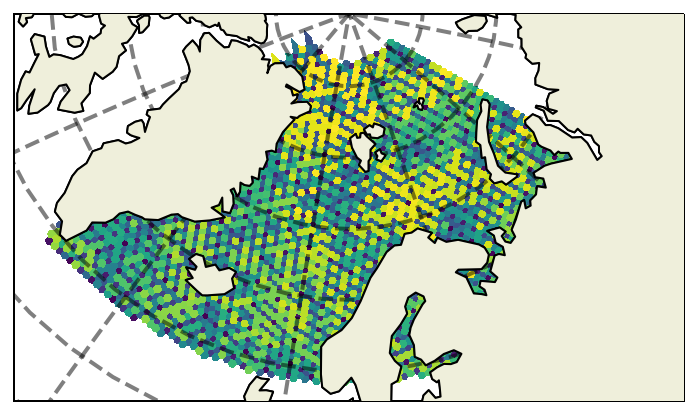

In [197]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.Stereographic(central_latitude=70, central_longitude=10.0))
ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, color='black', alpha=0.5, linestyle='--')
ax.coastlines()
ax.add_feature(cart.feature.LAND, zorder=5, edgecolor='k')
ax.set_extent((-50,70,57.5,90), crs=ccrs.PlateCarree())
ax.tripcolor(svTriLons, svTriLats, triangles=svSimplices[svMask], facecolors=svSimplices[:,0][svMask], transform=ccrs.Geodetic(), zorder=1)
plt.savefig("voronoi_bins.eps")
plt.show()

# Trial and error

In [93]:
# Create icosahedral mesh
ico = stripy.spherical_meshes.icosahedral_mesh(refinement_levels=5)
facepoints_lons, facepoints_lats = ico.face_midpoints()
icof = stripy.sTriangulation(np.hstack((ico.lons, facepoints_lons)), np.hstack((ico.lats, facepoints_lats)))
identifier = np.ones(icof.npoints)
identifier[ico.npoints:] = 0 # make index of last face 0
hex_id = icof.simplices[np.where(identifier[icof.simplices] == 1.0)]

In [94]:
hex_id.shape

(61440,)

In [ ]:
%%timeit
# Stripy method
ico.containing_triangle(testParticles.lons, testParticles.lats)

In [98]:
def spherical_angle(lon1, lat1, lon2, lat2, plot = False, debug=False):
    """
    Calculate spherical angle between lines ((northpole), (lon1, lat 1)) 
    and ((lon1, lat1), (lon2, lat2)), so the angle formed between a line straight down from the North Pole
    to point 1 and a line between point 1 and point 2. Angle is measured from North in counterclockwise
    direction.
    """
    if plot:
        degLon1 = np.degrees(lon1)
        degLat1 = np.degrees(lat1)
        degLon2 = np.degrees(lon2)
        degLat2 = np.degrees(lat2)
        fig = plt.figure(figsize=(5, 5))
        ax  = plt.axes(projection=ccrs.Orthographic(central_longitude = degLon1, 
                                                    central_latitude = degLat1))
        ax.coastlines()
        ax.set_global()
        ax.plot([0, degLon1], [90, degLat1], transform=ccrs.Geodetic())
        ax.plot([degLon1, degLon2], [degLat1, degLat2], transform=ccrs.Geodetic())
        ax.scatter(degLon1, degLat1, color="green", marker="o", s=40.0, transform=ccrs.Geodetic(), zorder=2)
        ax.scatter(degLon1, degLat1, color="red", marker="o", s=40.0, transform=ccrs.Geodetic(), zorder=2)
        ax.scatter(degLon2, degLat2, color="blue", marker="o", s=40.0, transform=ccrs.Geodetic(), zorder=2)
        plt.show()
        
    # Convert to cartesian coordinates
    # lon = angle with respect to x-axis
    # lat = angle with respect to y-axis
    # r   = 1,  unit circle
    x1 = np.cos(lon1)*np.cos(lat1)
    y1 = np.sin(lon1)*np.cos(lat1)
    z1 = np.sin(lat1)
    x2 = np.cos(lon2)*np.cos(lat2)
    y2 = np.sin(lon2)*np.cos(lat2)
    z2 = np.sin(lat2)
    # Vectors normal to plane between
    ref = np.array([0,0,1])
    if debug:
        print(np.array([x1,y1,z1]), np.array([x2,y2,z2]))
    v1 = np.cross(np.array([x1, y1, z1]), ref)
    v2 = np.cross(np.array([x1, y1, z1]), np.array([x2, y2, z2]))
    if debug:
        print("v1:", v1)
        print("v2:", v2)
        print("np.dot(v1, v2):", np.dot(v1, v2))
    # Dot product between normal vectors
    a = np.dot(v1, v2)/np.dot(np.linalg.norm(v1), np.linalg.norm(v2))
    a = np.where(a>1, 1, a)
    a = np.where(a<-1, -1, a)
    if debug:
        print("np.dot(v1, v2)/np.dot(np.linalg.norm(v1), np.linalg.norm(v2))", a)
    if np.sign(np.dot(v1, np.array([x2, y2, z2]))) >= 0:
        return np.arccos(a)
    else: 
        return -np.arccos(a)

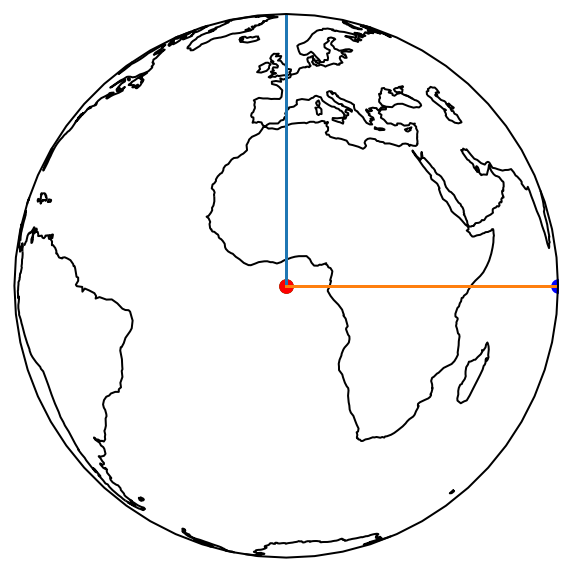

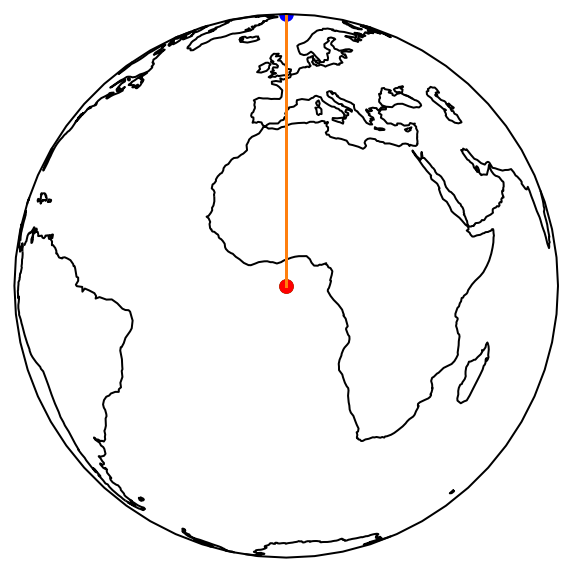

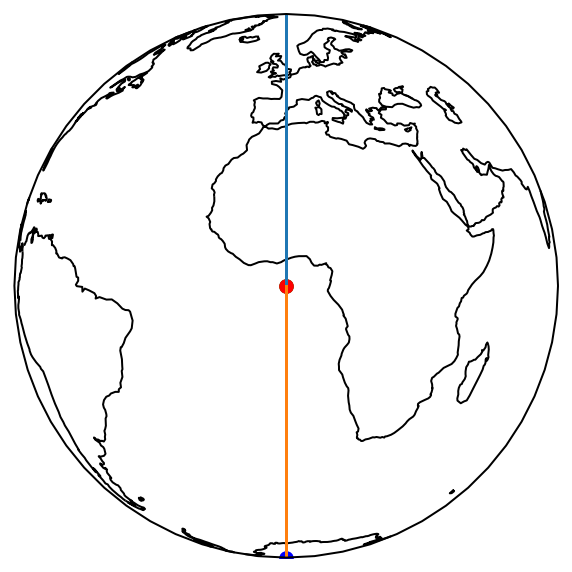

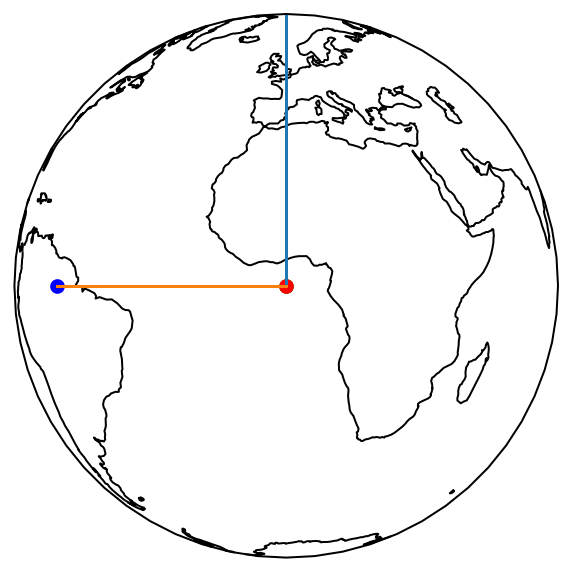

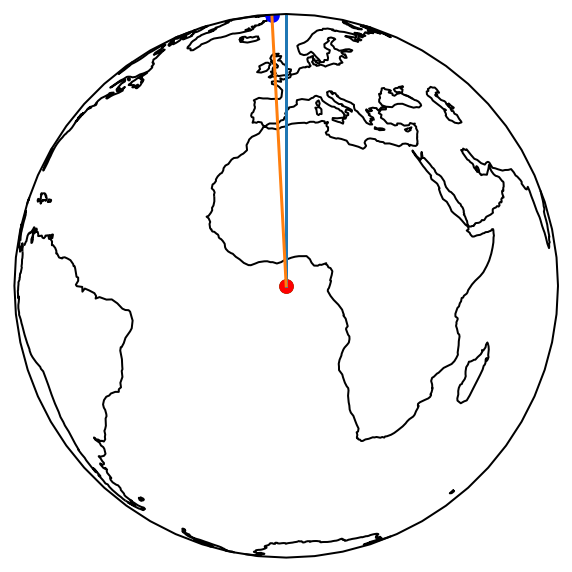

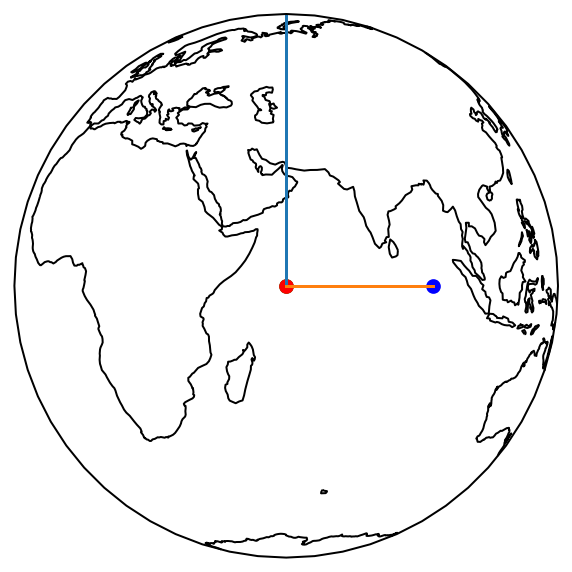

0,0, 0.5*np.pi, 0. Should be 0.5*pi: -1.5707963267948966
0,0, 0, 0.5*np.pi. Should be 0: 0.0
0,0, 0, -0.5*np.pi. Should be pi: 3.141592653589793
0,0, -1, 0. Should be -0,5*pi or 1.5*pi: 1.5707963267948966
0,0, -1, 0.48*np.pi. Should be very small: 0.0528914902728317
1, 0, 0.5*np.pi, 0. Should be 0.5*pi: -1.5707963267948966


In [99]:
test_a = spherical_angle(0, 0, 0.5*np.pi, 0, plot=True) #should be 0.5*pi
test_b = spherical_angle(0,0, 0, 0.5*np.pi, True) # should be 0
test_c = spherical_angle(0,0, 0, -0.5*np.pi, True) # should be pi
test_d = spherical_angle(0,0, -1, 0, True) # should be -0.5*pi or 1.5*pi
test_e = spherical_angle(0,0, -1, 0.48*np.pi, True) # should be very small
test_f = spherical_angle(1, 0, 0.5*np.pi, 0, plot=True) #should be 0.5*pi


print("0,0, 0.5*np.pi, 0. Should be 0.5*pi:", test_a)
print("0,0, 0, 0.5*np.pi. Should be 0:",test_b)
print("0,0, 0, -0.5*np.pi. Should be pi:", test_c)
print("0,0, -1, 0. Should be -0,5*pi or 1.5*pi:", test_d)
print("0,0, -1, 0.48*np.pi. Should be very small:", test_e)
print("1, 0, 0.5*np.pi, 0. Should be 0.5*pi:", test_f)

In [ ]:
# Create mask of domain in question
icoDomainMask = domainMask = np.logical_and(np.logical_and(np.degrees(icof.lats) > 60, 
                                           np.degrees(icof.lats) < 85),
                             np.logical_and(np.degrees(icof.lons) < 70,
                                           np.degrees(icof.lons) > -40))
subLons = icof.lons[icoDomainMask]
subLats = icof.lats[icoDomainMask]
# Save ids
vertexIdx = icof._permutation
# Save subset of IDs
subVertexIdx = vertexIdx[icoDomainMask]
# Create indices for each simplex (triangle)
simplexIdx = np.arange(icof._simplices.shape[0])
# Create empty dictionaries for lookup of neighbors of vertices, simplices that vertices are in
# and angles formed between vertices and their neighbors. vertexIDs are keys.
neighbors = {}
inSimplex = {}
neighborAngles = {}
neighborAnglesArrs = {}
for i in vertexIdx:
    neighbors[i] = set()
    inSimplex[i] = set()
    neighborAngles[i] = {}
    neighborAnglesArrs[i] = {}

# For each simplex, fill dictionary with simplex and neighbor information
for i in simplexIdx:   
    currSimplex = icof._simplices[i]
    inSimplex[currSimplex[0]].add(i)
    inSimplex[currSimplex[1]].add(i)
    inSimplex[currSimplex[2]].add(i)
    neighbors[currSimplex[0]].add(currSimplex[1])
    neighbors[currSimplex[0]].add(currSimplex[2])
    neighbors[currSimplex[1]].add(currSimplex[0])
    neighbors[currSimplex[1]].add(currSimplex[2])
    neighbors[currSimplex[2]].add(currSimplex[0])
    neighbors[currSimplex[2]].add(currSimplex[1])
# Calculate angles between vertices and their neighbors
for v, n in neighbors.items():
    for nv in n:
        neighborAngles[v][nv] = spherical_angle(icof.lons[v], icof.lats[v], icof.lons[nv], icof.lats[nv])    
# For each vertex, save the indices of its neighbors, as well as their angles.
# Sort these according to angles
for k, v in neighborAngles.items():
    n = len(v)
    indices = []
    angles = []
    for kk, vv in v.items():
        indices.append(kk)
        angles.append(vv)
    indices = np.array(indices)
    angles = np.array(angles)
    sort_idx = np.argsort(angles)
    sort_indices = indices[sort_idx]
    sort_angles = angles[sort_idx]
    neighborAnglesArrs[k]['indices'] = sort_indices 
    neighborAnglesArrs[k]['angles'] = sort_angles
    simplex = []
    for i in range(len(sort_indices)):
        simplex.append(list(inSimplex[k].intersection(inSimplex[sort_indices[i]], 
                                                      inSimplex[sort_indices[(i+1)%n]]))[0])
    neighborAnglesArrs[k]['simplex'] = np.array(simplex)
    neighborAnglesArrs[k]['hex_id'] = np.array([hex_id[s] for s in simplex])

# Simple Interpolation

In [60]:
from scipy.spatial import cKDTree

In [40]:
# Create icosahedral mesh
ico = stripy.spherical_meshes.icosahedral_mesh(refinement_levels=6)
facepoints_lons, facepoints_lats = ico.face_midpoints()
icof = stripy.sTriangulation(np.hstack((ico.lons, facepoints_lons)), np.hstack((ico.lats, facepoints_lats)))
identifier = np.ones(icof.npoints)
identifier[ico.npoints:] = 0 # make index of last face 0
hex_id = icof.simplices[np.where(identifier[icof.simplices] == 1.0)]

In [41]:
parts = community.particles.from_regular_grid(2000, 300, minLat=59, maxLat=86, minLon=-46, maxLon=66)

In [42]:
tree = scipy.spatial.cKDTree(np.dstack((ico.lons, ico.lats))[0])

In [43]:
tree.query(np.radians(parts.lonlat))

(array([[0.01711334, 0.01613862, 0.0151643 , ..., 0.05938443, 0.06010099,
         0.06082482]]),
 array([[ 7855,  7855,  7855, ..., 16024, 16024, 16024]]))

In [44]:
def get_cartesian(lat=None, lon=None, mode='rad'):
    if mode=='deg':
        lat, lon = np.deg2rad(lat), np.deg2rad(lon)
    R = 6371000 # radius of the earth
    x = R * np.cos(lat) * np.cos(lon)
    y = R * np.cos(lat) * np.sin(lon)
    z = R *np.sin(lat)
    return x,y,z

In [45]:
x, y, z = get_cartesian(facepoints_lats, facepoints_lons)

In [46]:
xp, yp, zp = get_cartesian(parts.lats, parts.lons, mode='deg')

In [47]:
grid_z0 = scipy.interpolate.griddata(6371000*ico.points, np.arange(ico.points.shape[0]), np.dstack((xp,yp,zp))[0], method='nearest')

In [48]:
facepoints_lons

array([ 3.14159265, -1.88495559, -0.62831853, ..., -1.84548713,
       -1.86272079, -1.87259737])

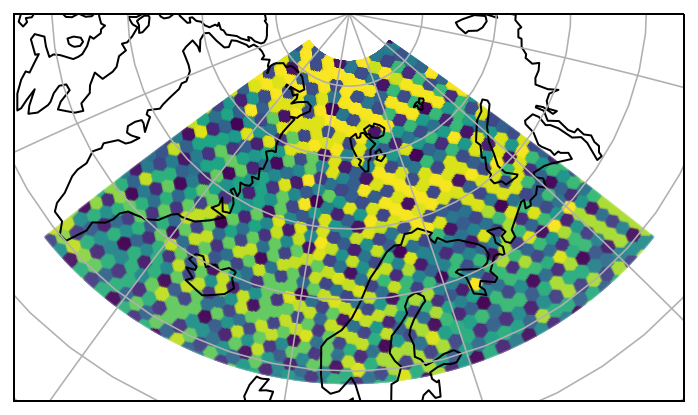

In [49]:
figure = plt.figure()
ax = plt.axes(projection=ccrs.Stereographic(central_latitude=70, central_longitude=10.0))
ax.gridlines()
ax.coastlines()
ax.set_extent((-50,70,57.5,90), crs=ccrs.PlateCarree())
ax.scatter(parts.lons, parts.lats, c=grid_z0, s=0.005, transform=cart.crs.PlateCarree())
plt.show()

# What are the facepoints

In [89]:
# Create icosahedral mesh
ico = stripy.spherical_meshes.icosahedral_mesh(refinement_levels=3)
facepoints_lons, facepoints_lats = ico.face_midpoints()
icof = stripy.sTriangulation(np.hstack((ico.lons, facepoints_lons)), np.hstack((ico.lats, facepoints_lats)))
identifier = np.ones(icof.npoints)
identifier[ico.npoints:] = 0 # make index of last face 0
hex_id = icof.simplices[np.where(identifier[icof.simplices] == 1.0)]

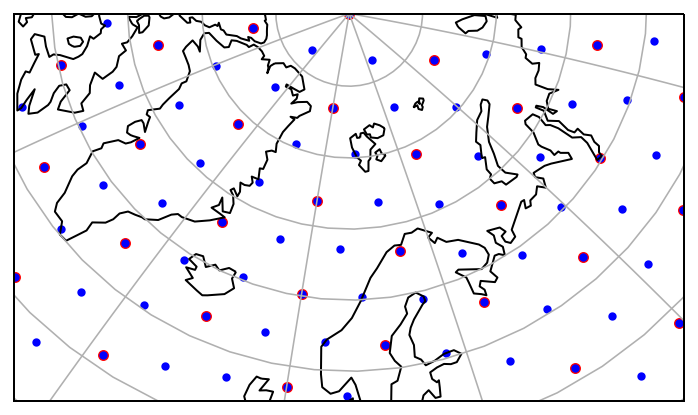

In [92]:
figure = plt.figure()
ax = plt.axes(projection=ccrs.Stereographic(central_latitude=70, central_longitude=10.0))
ax.gridlines()
ax.coastlines()
ax.set_extent((-50,70,57.5,90), crs=ccrs.PlateCarree())
ax.scatter(np.degrees(ico.lons), np.degrees(ico.lats), c='r', s=20, transform=cart.crs.PlateCarree())
ax.scatter(np.degrees(icof.lons), np.degrees(icof.lats), c='b', s=10, transform=cart.crs.PlateCarree())


plt.show()